## Customer Segmentation  practice

### 0: Install Libraries and Packages

In [51]:

# Core
import numpy as np
import pandas as pd 
import plotly.express as px

# Graphing 
import seaborn as sns
import matplotlib.pyplot as plt

# Clustering & PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 


# Machine Learning
#import pycaret.classification as clf

## 1: Load Data 
Using a dataset simulating customer data from a grocery store rewards program.
Kaggle https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

In [5]:
# Load raw data
data = pd.read_csv("data/marketing_campaign.csv", sep="\t")
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### 2: Data Pre-Processing
2.1 Look for and handle any 
- duplicates
- missing values

2.2 
- remove un-needed columns
- replace any column names for consistency
- Change categorical columns to label encoding or one-hot-encoding

In [14]:
# 2.1 Data Cleaning
print(f"Dataset has {data.shape[0]} rows and {data.shape[1]} columns.")
print(f"Data has {data.duplicated().sum()} duplicates and {data.isnull().sum().sum()} missing values.")

Dataset has 2240 rows and 29 columns.
Data has 0 duplicates and 24 missing values.


In [19]:
print(f"Column(s) with missing data values: {data.columns[data.isnull().any()][0]}")

Column(s) with missing data values: Income


Since only one column (Income) has null values and there are only 1% of rows with the null entries, I will drop the rows from our dataset.

In [20]:
# Dropping duplicates (just in case) and null values 
data.drop_duplicates(inplace=True) 
data.dropna(inplace=True)  

2.2 dealing with non-numeric columns

In [22]:
# Group columns by data type
grouped = data.columns.to_series().groupby(data.dtypes).groups

for dtype, columns in grouped.items():
    print(f"Columns with data type {dtype}: {', '.join(columns)}")

Columns with data type int64: ID, Year_Birth, Kidhome, Teenhome, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response
Columns with data type float64: Income
Columns with data type object: Education, Marital_Status, Dt_Customer


In [30]:
object_columns = data.select_dtypes(include=["object"]).columns
for col in object_columns:
    print(f"Unique values in column {col}: {data[col].nunique()}")

Unique values in column Education: 5
Unique values in column Marital_Status: 8
Unique values in column Dt_Customer: 662


In [32]:
data['Education'].value_counts()

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64

In [33]:
data['Marital_Status'].value_counts()

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [34]:
# Change Synonyms for single (Alone, Absurd, YOLO) to Single and (Together) to Married
data['Marital_Status'] = data['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')
data['Marital_Status'] = data['Marital_Status'].replace(['Together'], 'Married')

In [35]:
data['Dt_Customer'].value_counts()

Dt_Customer
31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
09-05-2014     1
26-06-2013     1
09-01-2014     1
Name: count, Length: 662, dtype: int64

In [38]:
# convert to datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%d-%m-%Y')

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-null   i

In [48]:
data.describe().T.iloc[:,-1].sort_values(ascending=False).head(15)

Income                 25173.076661
ID                      3249.376275
MntWines                  337.32792
MntMeatProducts          224.283273
MntFishProducts           54.752082
MntGoldProds              51.815414
MntSweetProducts          41.072046
MntFruits                 39.793917
Recency                   28.948352
Year_Birth                11.985554
NumStorePurchases          3.250785
NumCatalogPurchases        2.926734
NumWebPurchases            2.740951
NumWebVisitsMonth          2.425359
NumDealsPurchases          1.923716
Name: std, dtype: object

From reviewing the standard deviation of the numeric columns, it looks like the Income and MntWines and MntMeetProducts have a significantly large standard deviation.

<Axes: ylabel='Income'>

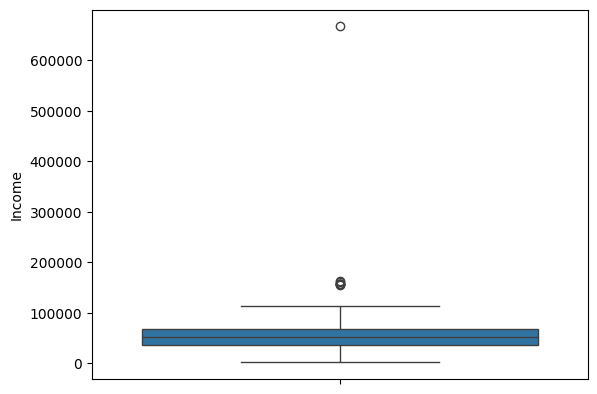

In [52]:
sns.boxplot(data['Income'])

In [55]:
data[data['Income']>600000]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
2233,9432,1977,Graduation,Married,666666.0,1,0,2013-06-02,23,9,...,6,0,0,0,0,0,0,3,11,0


In [57]:
# Lets drop the outlier of income over $600,000
data.drop(data[data['Income']>600000].index, inplace=True)
data.describe().T.iloc[:,-1].sort_values(ascending=False).head(15)

Income                 21526.320095
ID                      3249.082838
MntWines                  337.34538
MntMeatProducts          224.311559
MntFishProducts           54.760822
MntGoldProds               51.82266
MntSweetProducts          41.077594
MntFruits                 39.802036
Recency                   28.949608
Year_Birth                   11.987
NumStorePurchases          3.250974
NumCatalogPurchases        2.927179
NumWebPurchases            2.741473
NumWebVisitsMonth          2.425863
NumDealsPurchases           1.92382
Name: std, dtype: object

<Axes: >

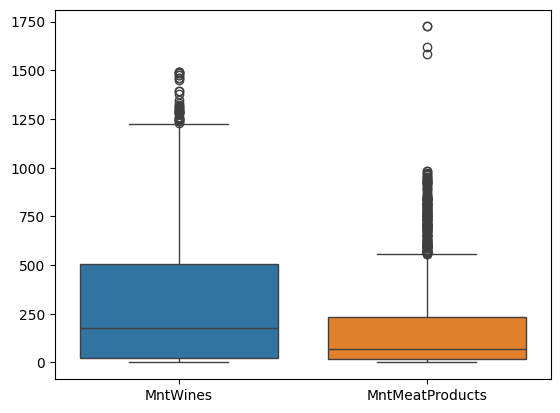

In [59]:
sns.boxplot(data[['MntWines','MntMeatProducts']])